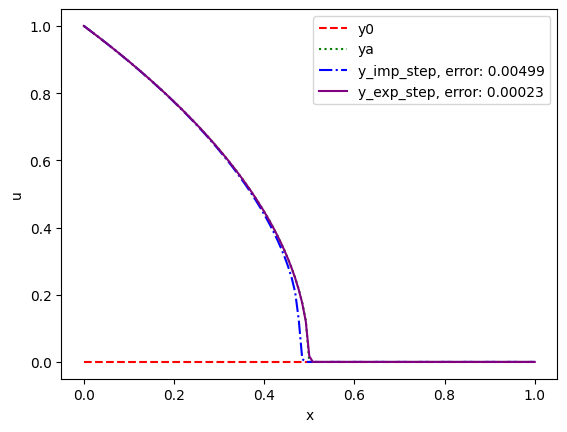

In [4]:
# Температурная волна k(u)(Самарский)
import sys
from math import sqrt
from matplotlib import pyplot as plt
import numpy as np


def u0(x):
    return 0.0


def phi_1(t):
    return u_0 * t ** (1 / sigma)


def phi_2(t):
    return 0.0


# coefficients
def k(u):
    if u < 0 and sigma % 2 == 0.5:
        return k_0 * (-u) ** sigma
    else:
        return k_0 * u ** sigma


def F(x):
    return 0.0


def norm_np(v1, v2):
    v1_np, v2_np = np.array(v1), np.array(v2)
    return np.mean(np.abs(v1_np - v2_np))


def u_a(x, t, sigma, D):
    if x <= D * t:
        return u_0 * t ** (1 / sigma) * (1 - x / (D * t)) ** (1 / sigma)

    return 0.0


n = 128
h = 1 / n
T = 0.5
m = 100
tau = T / m
# Меняем сигмы, для разных видов волн 0.5 1 2
sigma = 2 
#sigma = 0.5
#sigma = 1
k_0 = 1
D = 1
u_0 = (D * D * sigma / k_0) ** (1 / sigma)


def sweep(a, c, b, f, x0, xn, n):
    alpha = np.zeros(n + 1)
    beta = np.zeros(n + 1)
    beta[1] = x0
    x = np.zeros(n + 1)
    x[0], x[n] = x0, xn

    for i in range(1, n):
        d = a[i] * alpha[i] + c[i]
        alpha[i + 1] = -b[i] / d
        beta[i + 1] = (f[i] - a[i] * beta[i]) / d

    for i in range(n - 1, 0, -1):
        x[i] = alpha[i + 1] * x[i + 1] + beta[i + 1]

    return x


x = np.arange(0, n + 1) * h
t = np.arange(0, n + 1) * tau
ya = np.array([u_a(xi, T, sigma, D) for xi in x])
y0 = np.array([u0(xi) for xi in x])


def implicit_step(y, t, tau):
    ynew = np.array(y)
    ynew[0] = phi_1(t + tau)
    ynew[n] = phi_2(t + tau)

    a, b, c, f = np.zeros(n + 1), np.zeros(n + 1), np.zeros(n + 1), np.zeros(n + 1)
    for i in range(1, n):
        k_l = (k(y[i]) + k(y[i - 1])) / 2
        k_r = (k(y[i]) + k(y[i + 1])) / 2
        a[i] = -k_l
        b[i] = -k_r
        c[i] = h * h / tau + (k_l + k_r)
        f[i] = h * h * y[i] / tau

    ynew = sweep(a, c, b, f, ynew[0], ynew[n], n)
    return ynew


def explicit_step(y, t, tau):
    yn = np.zeros(n + 1)
    yn[0] = phi_1(t + tau)
    yn[n] = phi_2(t + tau)

    for i in range(1, n):
        k_1 = k((y[i] + y[i - 1]) / 2)
        k_2 = k((y[i + 1] + y[i]) / 2)
        yn[i] = y[i] + (tau / h / h) * (k_2 * y[i + 1] - (k_1 + k_2) * y[i] + k_1 * y[i - 1])

    return yn


def runge(y, t, tau, step):
    count = 0

    while True:
        v = step(y, t, tau)
        tau = tau / 2
        tmp = step(y, t, tau)
        w = step(tmp, t + tau, tau)

        if norm_np(v, w) < 1e-3:
            break

        count += 1

        if count > 10:
            print('Число итераций превышено')
            sys.exit()

    return v, tau * 2


y_imp_step = np.array(y0)
start = 0.0

while start < T:
    y_imp_step, tau = runge(y_imp_step, start, tau, implicit_step)
    start += tau

y_exp_step = np.array(y0)
start = 0.0

while start < T:
    y_exp_step, tau = runge(y_exp_step, start, tau, explicit_step)
    start += tau

fig, ax = plt.subplots()
ax.plot(x, y0, label='y0', color='red', linestyle='dashed')
ax.plot(x, ya, label='ya', color='green', linestyle='dotted')
ax.plot(x, y_imp_step, label=f'y_imp_step, error: {round(norm_np(y_imp_step, ya), 5)}', color='blue',
        linestyle='dashdot')
ax.plot(x, y_exp_step, label=f'y_exp_step, error: {round(norm_np(y_exp_step, ya), 5)}', color='purple',
        linestyle='solid')
legend = ax.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('u')
plt.show()


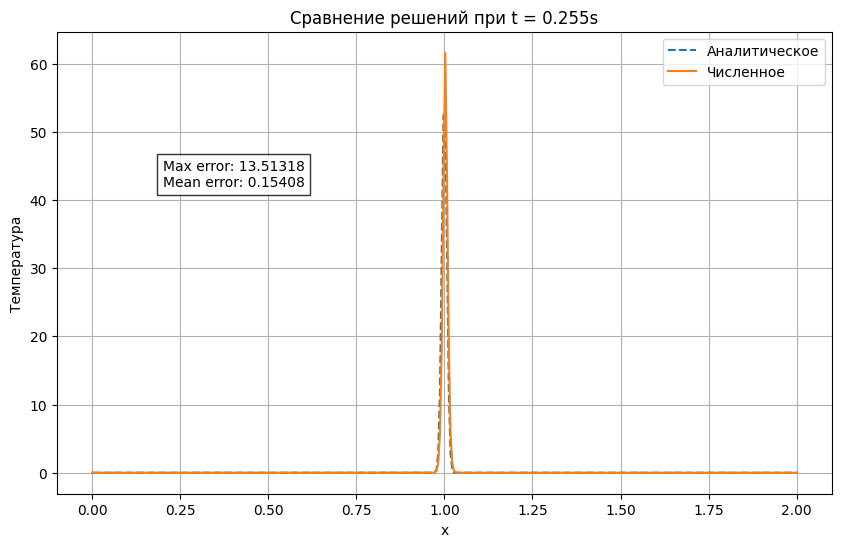

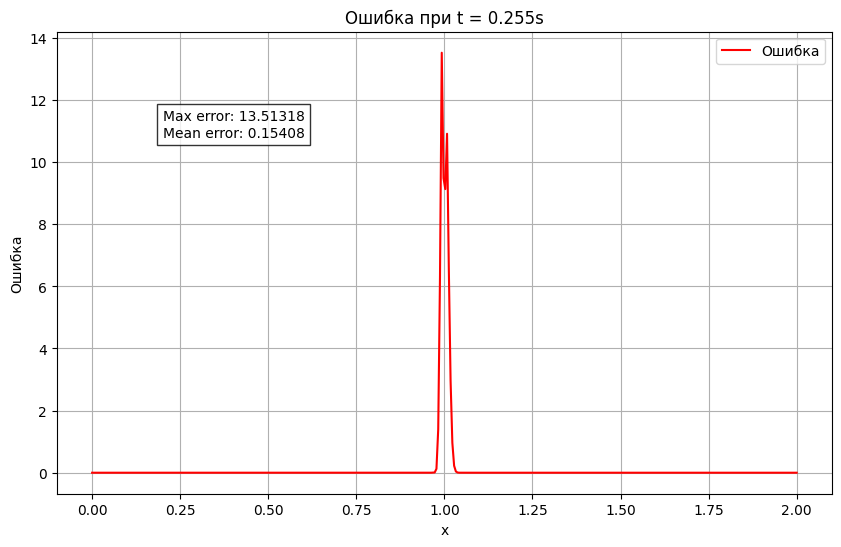

In [ ]:
# Температурная волна(Зельдович)(Из статьи)
import numpy as np
import matplotlib.pyplot as plt

L = 2.0
Nx = 400
T_max = 0.5
Nt = 500
alpha = 1e-4
Q = 1.0
x0 = L / 2
dx = L / (Nx - 1)
dt = T_max / Nt
x = np.linspace(0, L, Nx)
t = np.linspace(0.01, T_max, Nt)

T_analytic = np.zeros((Nt, Nx))
for k in range(Nt):
    for i in range(Nx):
        T_analytic[k, i] = Q / np.sqrt(4 * np.pi * alpha * t[k]) * np.exp(-((x[i] - x0)**2) / (4 * alpha * t[k]))

T_numeric = np.zeros((Nt, Nx))
T_numeric[0, Nx // 2] = Q / dx
for k in range(0, Nt - 1):
    for i in range(1, Nx - 1):
        T_numeric[k + 1, i] = T_numeric[k, i] + alpha * dt / dx**2 * (T_numeric[k, i + 1] - 2 * T_numeric[k, i] + T_numeric[k, i - 1])

# Вычисление ошибки
errors = np.abs(T_analytic - T_numeric)
time_index = Nt // 2  # Выбираем момент времени для сравнения
max_error = np.max(errors[time_index, :])
mean_error = np.mean(errors[time_index, :])

plt.figure(figsize=(10, 6))
plt.plot(x, T_analytic[time_index, :], label="Аналитическое", linestyle='--')
plt.plot(x, T_numeric[time_index, :], label="Численное", linestyle='-')
plt.xlabel("x")
plt.ylabel("Температура")
plt.title(f"Сравнение решений при t = {t[time_index]:.3f}s")
plt.legend()
plt.grid(True)
plt.text(0.1 * L, 0.8 * np.max(T_analytic[time_index, :]), 
         f"Max error: {max_error:.5f}\nMean error: {mean_error:.5f}", 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, errors[time_index, :], label="Ошибка", color='red')
plt.xlabel("x")
plt.ylabel("Ошибка")
plt.title(f"Ошибка при t = {t[time_index]:.3f}s")
plt.legend()
plt.grid(True)
plt.text(0.1 * L, 0.8 * max_error, 
         f"Max error: {max_error:.5f}\nMean error: {mean_error:.5f}", 
         bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
plt.show()


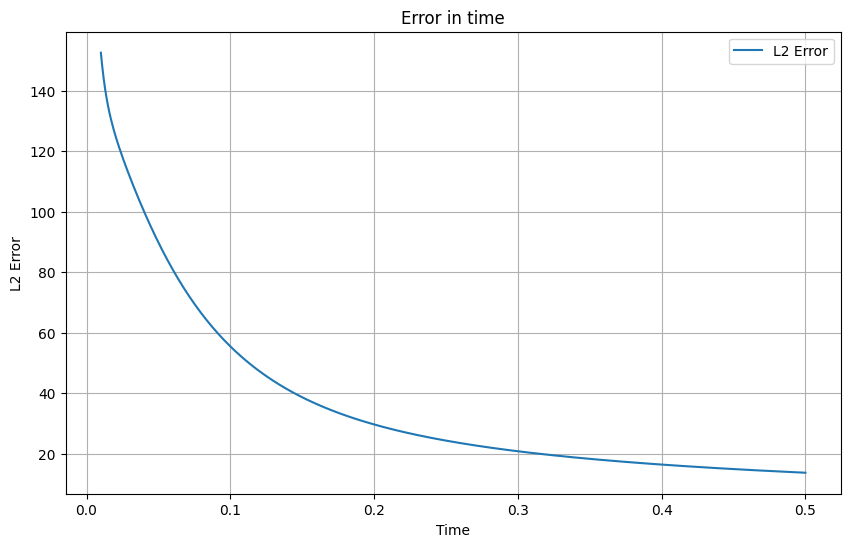

In [21]:
errors = np.zeros(Nt)
for k in range(Nt):
 errors[k] = np.sqrt(np.sum((T_analytic[k, :] -
T_numeric[k, :])**2))
plt.figure(figsize=(10, 6))
plt.plot(t, errors, label="L2 Error")
plt.xlabel("Time")
plt.ylabel("L2 Error")
plt.title("Error in time")
plt.legend()
plt.grid(True)
plt.show()

Тесты

C:\Users\danii\AppData\Local\Temp\ipykernel_20544\1553559860.py:42: RuntimeWarning: invalid value encountered in scalar divide
  return u_0 * t ** (1 / sigma) * (1 - x / (D * t)) ** (1 / sigma)


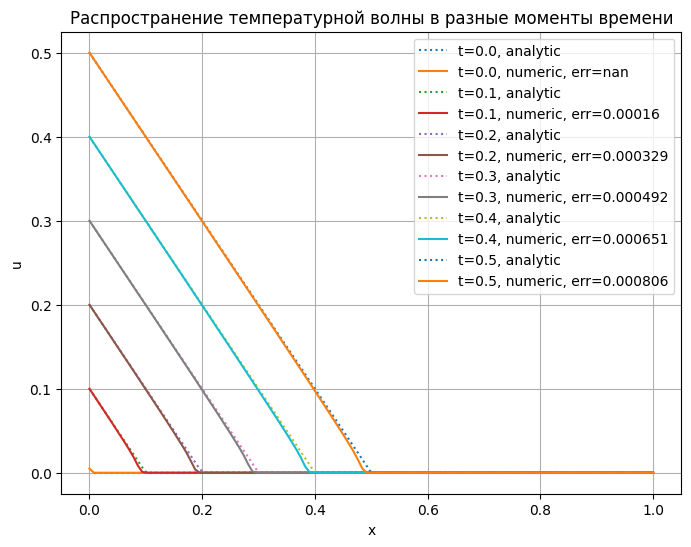

In [9]:
'''
import sys
from math import sqrt
from matplotlib import pyplot as plt
import numpy as np


def u0(x):
    return 0.0


def phi_1(t):
    return u_0 * t ** (1 / sigma)


def phi_2(t):
    return 0.0


def k(u):
    if u < 0 and sigma % 2 == 0.5:
        return k_0 * (-u) ** sigma
    else:
        return k_0 * u ** sigma


def F(x):
    return 0.0


def norm_np(v1, v2):
    v1_np, v2_np = np.array(v1), np.array(v2)
    return np.mean(np.abs(v1_np - v2_np))


def u_a(x, t, sigma, D):
    if x <= D * t:
        return u_0 * t ** (1 / sigma) * (1 - x / (D * t)) ** (1 / sigma)
    return 0.0


n = 128
h = 1 / n
T = 0.5
m = 100
tau = T / m
sigma = 1 
k_0 = 1
D = 1
u_0 = (D * D * sigma / k_0) ** (1 / sigma)


def sweep(a, c, b, f, x0, xn, n):
    alpha = np.zeros(n + 1)
    beta = np.zeros(n + 1)
    beta[1] = x0
    x = np.zeros(n + 1)
    x[0], x[n] = x0, xn

    for i in range(1, n):
        d = a[i] * alpha[i] + c[i]
        alpha[i + 1] = -b[i] / d
        beta[i + 1] = (f[i] - a[i] * beta[i]) / d

    for i in range(n - 1, 0, -1):
        x[i] = alpha[i + 1] * x[i + 1] + beta[i + 1]

    return x


def implicit_step(y, t, tau):
    ynew = np.array(y)
    ynew[0] = phi_1(t + tau)
    ynew[n] = phi_2(t + tau)

    a, b, c, f = np.zeros(n + 1), np.zeros(n + 1), np.zeros(n + 1), np.zeros(n + 1)
    for i in range(1, n):
        k_l = (k(y[i]) + k(y[i - 1])) / 2
        k_r = (k(y[i]) + k(y[i + 1])) / 2
        a[i] = -k_l
        b[i] = -k_r
        c[i] = h * h / tau + (k_l + k_r)
        f[i] = h * h * y[i] / tau

    ynew = sweep(a, c, b, f, ynew[0], ynew[n], n)
    return ynew


def explicit_step(y, t, tau):
    yn = np.zeros(n + 1)
    yn[0] = phi_1(t + tau)
    yn[n] = phi_2(t + tau)

    for i in range(1, n):
        k_1 = k((y[i] + y[i - 1]) / 2)
        k_2 = k((y[i + 1] + y[i]) / 2)
        yn[i] = y[i] + (tau / h / h) * (k_2 * y[i + 1] - (k_1 + k_2) * y[i] + k_1 * y[i - 1])

    return yn


def runge(y, t, tau, step):
    count = 0
    while True:
        v = step(y, t, tau)
        tau_half = tau / 2
        tmp = step(y, t, tau_half)
        w = step(tmp, t + tau_half, tau_half)

        if norm_np(v, w) < 1e-3:
            break

        tau = tau_half
        count += 1
        if count > 10:
            print('Число итераций превышено')
            sys.exit()

    return v, tau


x = np.arange(0, n + 1) * h
y0 = np.array([u0(xi) for xi in x])

times_to_save = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
saved_solutions = []
saved_analytic = []

y_imp_step = np.array(y0)
start = 0.0
cur_tau = tau

idx = 0
while start < T:
    if start + cur_tau > T:
        cur_tau = T - start
    y_imp_step, cur_tau = runge(y_imp_step, start, cur_tau, implicit_step)
    start += cur_tau
    # Сохраняем решение, если мы прошли один из временных слоев
    while idx < len(times_to_save) and start >= times_to_save[idx]:
        t_snap = times_to_save[idx]
        # если мы прошли время точнее, можно интерполировать или просто взять текущее
        # для простоты - возьмём текущее состояние как приближение
        # (предполагаем, что шаги по времени достаточно малы)
        # или можно было бы отдельно решить с фиксированным шагом
        ya = np.array([u_a(xi, t_snap, sigma, D) for xi in x])
        saved_solutions.append((t_snap, y_imp_step.copy()))
        saved_analytic.append((t_snap, ya))
        idx += 1

# Теперь построим графики для нескольких времен, чтобы показать движение фронта
fig, ax = plt.subplots(figsize=(8,6))
for (t_snap, y_num), (_, ya) in zip(saved_solutions, saved_analytic):
    ax.plot(x, ya, linestyle='dotted', label=f"t={t_snap}, analytic")
    ax.plot(x, y_num, linestyle='solid', label=f"t={t_snap}, numeric, err={round(norm_np(y_num, ya),6)}")

ax.set_xlabel('x')
ax.set_ylabel('u')
ax.set_title('Распространение температурной волны в разные моменты времени')
ax.legend()
plt.grid(True)
plt.show()
'''

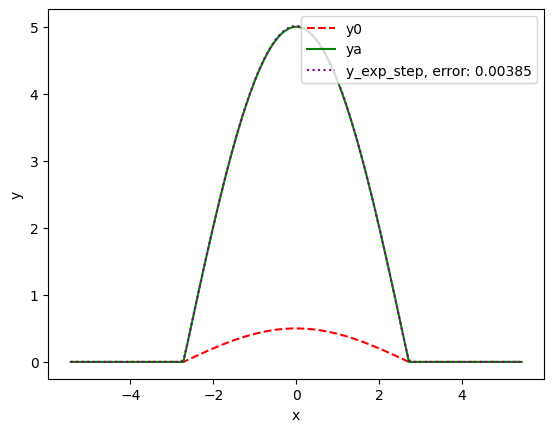

In [23]:
#  Обострение(горение) S-режим

import sys
from math import sqrt, cos, pi
from matplotlib import pyplot as plt
import numpy as np


def u0(x):
    if abs(x) < Ls / 2:
        return (sqrt(3) / 2 * cos(pi * x / Ls)) * 1 / sqrt(T)
    return 0.0


def phi_1(t):
    return 0.0


def phi_2(t):
    return 0.0


def k(u):
    return k_0 * u * u


def f(u, beta):
    return u ** beta


def norm_np(v1, v2):
    v1_np, v2_np = np.array(v1), np.array(v2)
    return np.mean(np.abs(v1_np - v2_np))


def u_a(x, t):
    if abs(x) < Ls / 2:
        return ((sqrt(3) / 2) * cos(pi * x / Ls)) * 1 / sqrt(T - t)
    return 0


beta = 3
T = 3.0  # 2, 3
End = 0.99 * T
n = 128
Ls = pi * sqrt(3)
h = 2 * Ls / n
m = 100 * int(Ls)
k_0 = 1
tau = T / m

x = np.arange(n + 1) * h - Ls
ya = np.array([u_a(xi, End) for xi in x])
y0 = np.array([u0(xi) for xi in x])


def explicit_step(y, t, tau):
    yn = np.zeros(n + 1)
    yn[0] = phi_1(t)
    yn[n] = phi_2(t)

    for i in range(1, n):
        mu_l = k(0.5 * (y[i - 1] + y[i]))
        mu_r = k(0.5 * (y[i] + y[i + 1]))
        yn[i] = y[i] + (tau / h / h) * (mu_r * y[i + 1] - (mu_l + mu_r) * y[i] + mu_l * y[i - 1]) + tau * f(y[i], beta)

    return yn


def runge(y, t, tau, step):
    count = 0

    while True:
        v = step(y, t, tau)
        tau = tau / 2
        tmp = step(y, t, tau)
        w = step(tmp, t + tau, tau)

        if norm_np(v, w) < 1e-8:
            break

        count += 1

        if count > 10:
            print('Число итераций превышено')
            sys.exit()

    return v, tau * 2


y_exp = np.array(y0)
start = 0

while start < End:
    y_exp, tau = runge(y_exp, start, tau, explicit_step)
    start += tau

fig, ax = plt.subplots()
ax.plot(x, y0, label='y0', color='red', linestyle='dashed')
ax.plot(x, ya, label='ya', color='green', linestyle='solid')
ax.plot(x, y_exp, label=f'y_exp_step, error: {round(norm_np(y_exp, ya), 5)}', color='purple',
        linestyle='dotted')
legend = ax.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


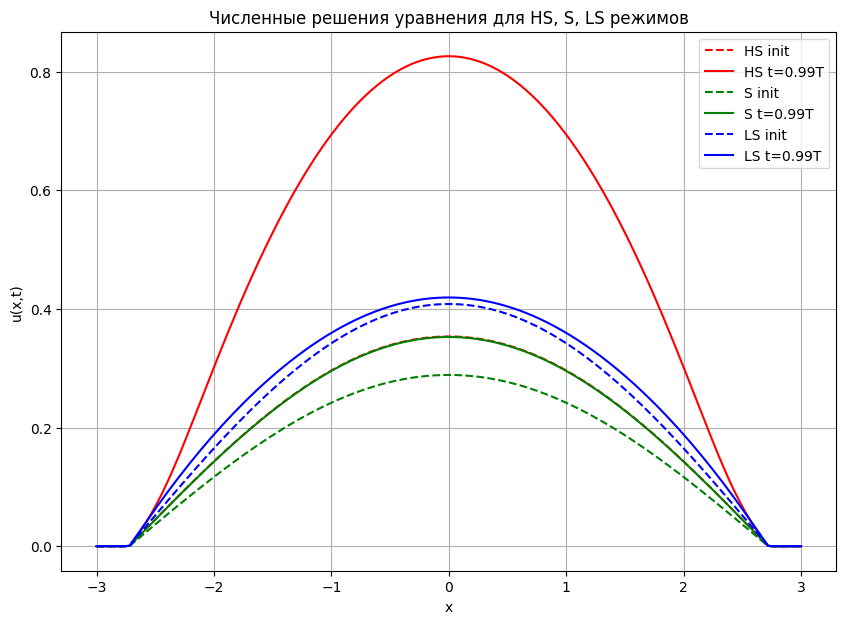

In [25]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, cos, pi

# ---------------------
# ПАРАМЕТРЫ, ОБЩИЕ ДЛЯ ВСЕХ РЕЖИМОВ
# ---------------------

k_0 = 1.0          # коэффициент при теплопроводности
n   = 128          # число узлов по пространству
m   = 400          # базовое число шагов по времени
                   # (можно увеличить при "получении взрыва")
Lx  = 3.0          # полуширина расчётной области ([-Lx, Lx])

# Сетка по x
x_min, x_max = -Lx, Lx
h = (x_max - x_min)/n
x = np.linspace(x_min, x_max, n+1)

# Граничные условия (здесь - простые однородные Дирихле)
def phi_1(t):
    return 0.0

def phi_2(t):
    return 0.0

# Коэффициент теплопроводности k(u)=k0*u^2
def k(u):
    return k_0 * (u*u)

# Источник f(u)=u^beta
def f(u, beta):
    return u**beta

# Норма для контроля сходимости (просто L1-средняя)
def norm_np(v1, v2):
    v1_np, v2_np = np.array(v1), np.array(v2)
    return np.mean(np.abs(v1_np - v2_np))

# ---------------------
# ЯВНЫЙ ШАГ со смешанным "subcycle" контролем
# ---------------------
def explicit_step(y, t, tau, beta):
    """
    Один шаг явной схемы:
    y[n+1] = y[n] + tau*((k(u)*ux)_x + f(u,beta)).
    """
    n_loc = len(y) - 1
    yn = np.zeros(n_loc+1)

    # Границы
    yn[0]   = phi_1(t)
    yn[n_loc] = phi_2(t)

    # Центральные узлы
    for i in range(1, n_loc):
        mu_l = k(0.5 * (y[i - 1] + y[i]))     # k(u) слева
        mu_r = k(0.5 * (y[i]     + y[i + 1])) # k(u) справа
        
        # Явная схема для (mu * ux)_x
        # (u[i+1] - 2u[i] + u[i-1]) умножается на соответствующие mu_r / mu_l
        d2 = ( mu_r*(y[i+1] - y[i]) - mu_l*(y[i] - y[i-1]) )/(h*h)
        
        yn[i] = y[i] + tau * ( d2 + f(y[i], beta) )

    return yn

def runge_kutt_like(y, t, tau, beta, step_func):
    """
    Простейший приём: делаем шаг tau, потом два шага по tau/2,
    сравниваем, если достаточно близко — принимаем,
    иначе уменьшаем шаг и повторяем.
    """
    count_iter = 0
    while True:
        # Один «крупный» шаг
        y_big = step_func(y, t,       tau, beta)
        # Два «малых» шага
        y_half = step_func(y, t,       tau/2, beta)
        y_half = step_func(y_half, t + tau/2, tau/2, beta)
        
        err = norm_np(y_big, y_half)
        if err < 1e-6:
            # Шаг удался
            return y_half, tau  # Можно вернуть и y_half (почти = y_big)
        
        # Иначе уменьшаем шаг и повторяем
        tau /= 2
        count_iter += 1
        if count_iter > 15:
            print("Слишком много делений шага по времени, выходим.")
            sys.exit()


# ---------------------
# ФУНКЦИЯ-ЗАПУСКАЛКА ДЛЯ ДАННОГО РЕЖИМА
# ---------------------
def solve_regime(beta, T, initial_profile='cos'):
    """
    beta = 2 (HS), 3 (S), 4 (LS)
    T    - предполагаемое "время обострения"
    initial_profile = 'cos' или 'bump' и т.п.
    """
    # Задаём начальное условие
    if initial_profile == 'cos':
        # По аналогии с S-режимом, делаем "кусочно-косинусное" 
        # в центральной части, 0 - вне. 
        # При этом амплитуды и т.д. можно подогнать под нужный режим.
        def u0(xi):
            # Возьмём "длину носителя" Ls=pi*sqrt(3) как в S-режиме, 
            # но можно и другую
            Ls_local = np.pi * sqrt(3)
            if abs(xi) < Ls_local/2:
                # Для S-режима (beta=3) было ~ cos(...) / sqrt(T)
                # Для HS (beta=2) и LS (beta=4) можно просто 
                # уменьшить амплитуду, чтобы вначале решение было гладким.
                return 0.5*cos(pi*xi/Ls_local)/sqrt(T) 
            return 0.0
    else:
        # «Гладкая» «бугор»-функция на всем интервале
        def u0(xi):
            return 0.1 * np.exp(-3*xi*xi)
    
    # Заполним начальный вектор
    y_init = np.array([u0(xi) for xi in x])
    
    # Будем идти до t ~ 0.99*T, т.к. к T решение "улетает"
    t_end = 0.99*T
    
    # Шаг по времени возьмём как T/m (похоже на Ваш код)
    tau = T/m
    
    # Основной цикл по времени
    y_sol = y_init.copy()
    t_cur = 0.0
    
    while t_cur < t_end:
        # если вдруг близко к концу, уменьшим шаг
        if t_cur + tau > t_end:
            tau = t_end - t_cur
        
        y_new, real_tau = runge_kutt_like(y_sol, t_cur, tau, beta, explicit_step)
        y_sol = y_new
        t_cur += real_tau
    
    return x, y_init, y_sol

# ---------------------
# ЗАПУСКИ ДЛЯ ТРЁХ РЕЖИМОВ
# ---------------------
plt.figure(figsize=(10,7))

# 1) HS-режим (beta=2)
beta_hs = 2
T_hs = 2.0  # время "взрыва" (условно)
x_hs, y0_hs, y_end_hs = solve_regime(beta_hs, T_hs)
plt.plot(x_hs, y0_hs,   'r--',  label='HS init')
plt.plot(x_hs, y_end_hs,'r-',   label='HS t=0.99T')

# 2) S-режим (beta=3) -- Ваш исходный
beta_s = 3
T_s = 3.0
x_s, y0_s, y_end_s = solve_regime(beta_s, T_s)
plt.plot(x_s, y0_s,   'g--',  label='S init')
plt.plot(x_s, y_end_s,'g-',   label='S t=0.99T')

# 3) LS-режим (beta=4)
beta_ls = 4
T_ls = 1.5  # Он может "обостряться" ещё быстрее, чем S
x_ls, y0_ls, y_end_ls = solve_regime(beta_ls, T_ls)
plt.plot(x_ls, y0_ls,   'b--',  label='LS init')
plt.plot(x_ls, y_end_ls,'b-',   label='LS t=0.99T')

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Численные решения уравнения для HS, S, LS режимов')
plt.legend()
plt.grid(True)
plt.show()


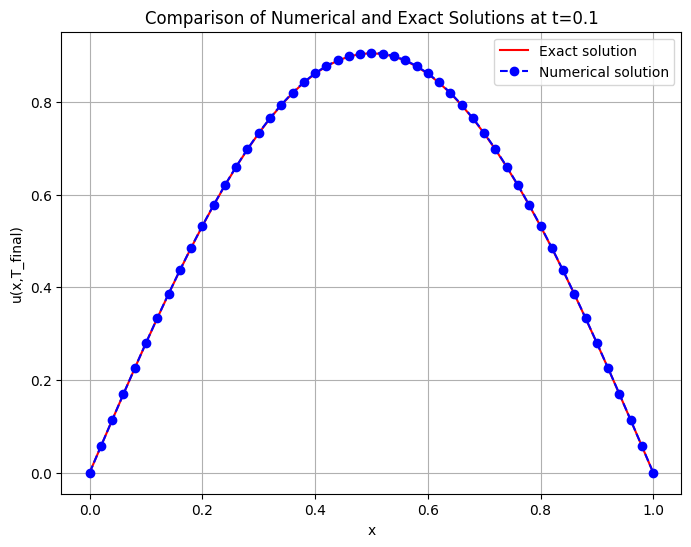

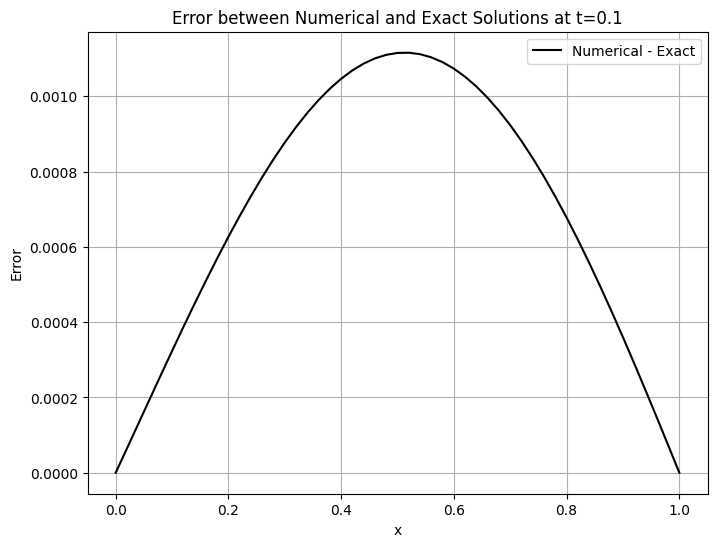

In [2]:
import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt

# Parameters
N = 50            # number of spatial subintervals
h = 1.0 / N       # spatial step size
x = np.linspace(0, 1, N+1)
T_final = 0.1
dt = 0.001
gamma = 1.0        # Rosenbrock parameter

# Exact solution and forcing term
def u_exact(x,t):
    return np.exp(-t)*np.sin(np.pi*x)

def f_func(x,t):
    return np.exp(-t)*((np.pi**2*(x+2)-1)*np.sin(np.pi*x) - 2*np.pi*np.cos(np.pi*x))

# Initial condition
U = u_exact(x,0)

# Construct matrix A and vector for f(x,t)
# Using central differences
M = N-1  # number of interior points
A = np.zeros((M,M))

for k in range(M):
    j = k+1   # j runs from 1 to N-1
    xj = x[j]
    # Coefficients
    coeff = (xj+2)/(h**2)
    # du_j/dt = (x_j+2)* ( (u_{j+1}-2u_j+u_{j-1})/h^2 ) + 2((u_{j+1}-u_{j-1})/(2h))
    # Simplify second derivative and first derivative approximations:
    # second deriv contributes: -2*coeff on diag, coeff on upper and lower
    # first deriv contributes: + (1/h)* on upper and - (1/h)* on lower

    A[k,k] = A[k,k] - 2*coeff  # main diagonal
    if k < M-1:
        A[k,k+1] = A[k,k+1] + coeff + (1.0/h)
    if k > 0:
        A[k,k-1] = A[k,k-1] + coeff - (1.0/h)

# Forcing term and boundary conditions:
# u(0,t)=0, u(1,t)=0 are directly applied by not including these in the unknown vector.
# We just need to include their effect in f if it existed.
# Here, boundaries are zero, so no direct modification needed other than ensuring U_0=0, U_N=0.

def RHS_func(U_interior,t):
    # U_interior corresponds to [u_1, u_2, ..., u_{N-1}]
    # Construct full U with boundaries
    U_full = np.zeros(N+1)
    U_full[1:-1] = U_interior

    # Evaluate f(x,t) at interior points:
    f_vals = np.array([f_func(x[j],t) for j in range(1,N)])
    
    # PDE: U_t = A U_interior + f_vals
    return A @ U_interior + f_vals

# Extract the interior part
U_interior = U[1:-1].copy()

I = np.eye(M)

# Time integration using a one-stage Rosenbrock:
# U_{n+1} = U_n + dt (I - gamma*dt*A)^{-1}[A U_n + f]
for step in range(int(T_final/dt)):
    t_n = step*dt
    RHS = RHS_func(U_interior, t_n)
    LHS = (I - gamma*dt*A)
    K = solve(LHS, RHS)
    U_interior = U_interior + dt*K

# Combine back solution
U_num = np.zeros(N+1)
U_num[1:-1] = U_interior

# Compute exact solution at final time
U_ex = u_exact(x,T_final)

# Plot comparison
plt.figure(figsize=(8,6))
plt.plot(x, U_ex, 'r-', label='Exact solution')
plt.plot(x, U_num, 'bo--', label='Numerical solution')
plt.xlabel('x')
plt.ylabel('u(x,T_final)')
plt.title('Comparison of Numerical and Exact Solutions at t={}'.format(T_final))
plt.legend()
plt.grid(True)
plt.show()

# Plot the difference
plt.figure(figsize=(8,6))
plt.plot(x, U_num - U_ex, 'k-', label='Numerical - Exact')
plt.xlabel('x')
plt.ylabel('Error')
plt.title('Error between Numerical and Exact Solutions at t={}'.format(T_final))
plt.legend()
plt.grid(True)
plt.show()


Max (L^∞) error at t = 0.1: 1.115594e-03
L^2 (RMS) error at t = 0.1: 7.794817e-04
Mean absolute error at t = 0.1: 6.938829e-04


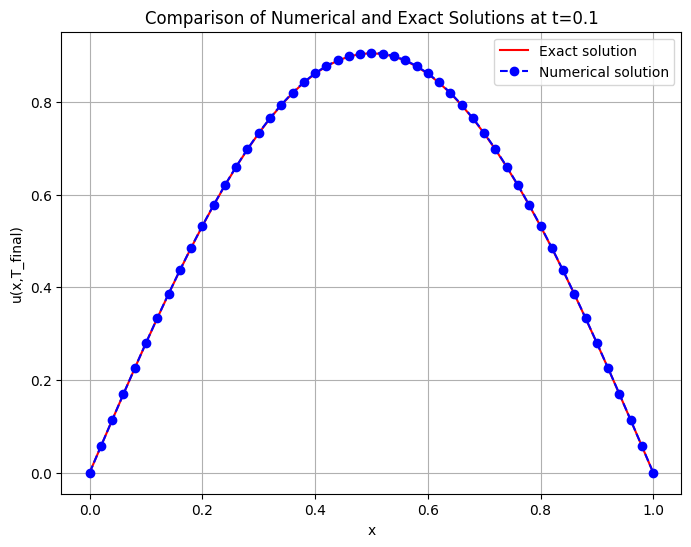

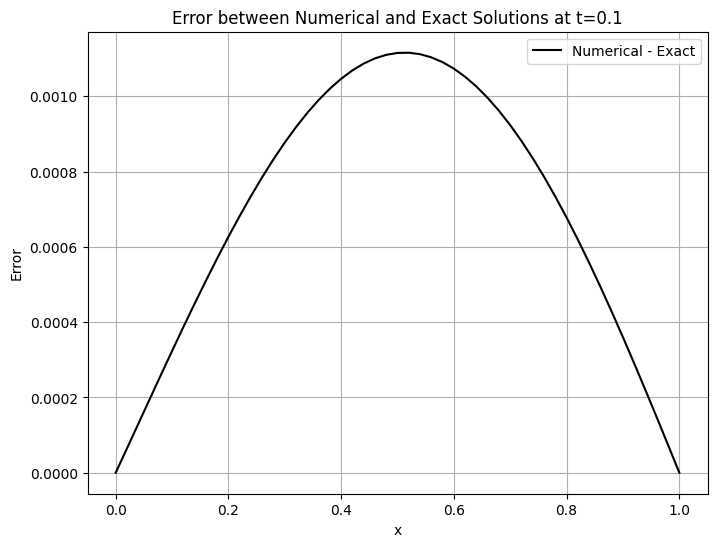

In [3]:
import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt

# Параметры
N = 50             # число промежутков по x
h = 1.0 / N        # шаг по x
x = np.linspace(0, 1, N+1)
T_final = 0.1      # конечное время
dt = 0.001         # шаг по времени
gamma = 1.0        # Параметр (например, для Rosenbrock)

# Точное решение и соответствующая правая часть f(x,t)
def u_exact(x, t):
    """ Точное решение: u(x,t) = e^{-t} * sin(pi*x). """
    return np.exp(-t)*np.sin(np.pi*x)

def f_func(x, t):
    """
    Правая часть PDE, выведенная так, чтобы u_exact было решением:
        u_t = (x+2) u_{xx} + 2 u_x + f(x,t).
    """
    return np.exp(-t)*((np.pi**2*(x+2)-1)*np.sin(np.pi*x) - 2*np.pi*np.cos(np.pi*x))

# Начальное условие
U = u_exact(x, 0.0)

# Полусвязная (по пространству) система:
# Строим матрицу A, отвечающую оператору (x+2)*u_xx + 2u_x на внутренних узлах.
M = N-1  # число внутренних узлов (исключаем граничные точки x=0 и x=1)
A = np.zeros((M,M))

for k in range(M):
    j = k+1   # индекс в полном векторе U
    xj = x[j]

    # Коэффициент при u''(x_j)
    coeff = (xj+2)/(h**2)

    # Составляем дискретизацию с учётом:
    #  u_xx ~ (u_{j+1} - 2u_j + u_{j-1}) / h^2
    #  u_x  ~ (u_{j+1} - u_{j-1}) / (2 h)
    # После аккуратных преобразований получаем вклад в матрицу A:
    A[k,k] -= 2*coeff  # диагональ
    if k < M-1:        # верхняя наддиагональ
        A[k,k+1] += coeff + (1.0/h)
    if k > 0:          # нижняя поддиагональ
        A[k,k-1] += coeff - (1.0/h)

# Функция для вычисления правой части (A U_interior + f)
def RHS_func(U_interior, t):
    # Восстановим полный вектор U (учитывая, что на границах U=0)
    U_full = np.zeros(N+1)
    U_full[1:-1] = U_interior
    
    # Значения f(x_j, t) на внутренних узлах j = 1..N-1
    f_vals = np.array([f_func(x[j], t) for j in range(1,N)])
    
    return A @ U_interior + f_vals

# Выделяем внутренние узлы
U_interior = U[1:-1].copy()

# Для решения системы на каждом шаге
I = np.eye(M)

# Интегрируем по времени методом (упрощённым) Rosenbrock на каждом шаге:
steps = int(T_final/dt)
for step in range(steps):
    t_n = step*dt
    
    # Правая часть
    RHS = RHS_func(U_interior, t_n)
    
    # (I - gamma*dt*A)*K = RHS  =>  K = ...
    LHS = (I - gamma*dt*A)
    K = solve(LHS, RHS)
    
    # U_interior^{n+1} = U_interior^n + dt*K
    U_interior = U_interior + dt*K

# Собираем решение обратно, включая граничные точки
U_num = np.zeros(N+1)
U_num[1:-1] = U_interior

# Считаем точное решение в момент времени T_final
U_ex = u_exact(x, T_final)

# ------------------ 1) Численный вывод ошибки в консоль ---------------------

# 1a) Максимальная абсолютная ошибка (L^∞-норма)
max_error = np.max(np.abs(U_num - U_ex))

# 1b) Среднеквадратичная ошибка (L^2-ориентированная)
l2_error = np.sqrt(np.mean((U_num - U_ex)**2))

# 1c) Средняя абсолютная ошибка
mean_abs_error = np.mean(np.abs(U_num - U_ex))

print(f"Max (L^∞) error at t = {T_final}: {max_error:.6e}")
print(f"L^2 (RMS) error at t = {T_final}: {l2_error:.6e}")
print(f"Mean absolute error at t = {T_final}: {mean_abs_error:.6e}")

# ------------------ 2) Графический вывод решения ---------------------------
plt.figure(figsize=(8,6))
plt.plot(x, U_ex, 'r-', label='Exact solution')
plt.plot(x, U_num, 'bo--', label='Numerical solution')
plt.xlabel('x')
plt.ylabel('u(x,T_final)')
plt.title(f'Comparison of Numerical and Exact Solutions at t={T_final}')
plt.legend()
plt.grid(True)
plt.show()

# ------------------ 3) Графический вывод ошибки ---------------------------
plt.figure(figsize=(8,6))
plt.plot(x, U_num - U_ex, 'k-', label='Numerical - Exact')
plt.xlabel('x')
plt.ylabel('Error')
plt.title(f'Error between Numerical and Exact Solutions at t={T_final}')
plt.legend()
plt.grid(True)
plt.show()


Max error over [0, 0.1]: 1.115594e-03
Mean error over [0, 0.1]: 7.924916e-04


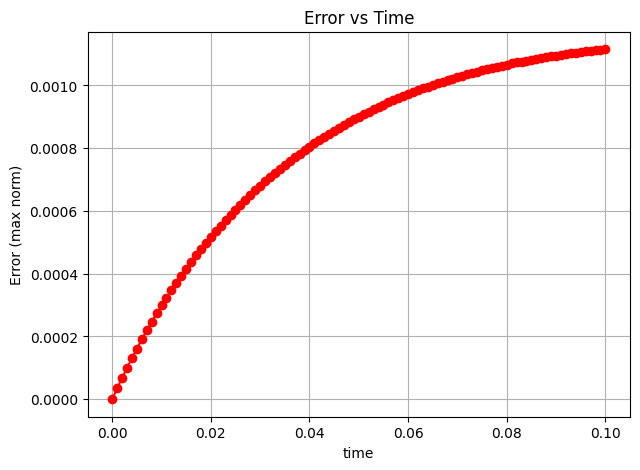

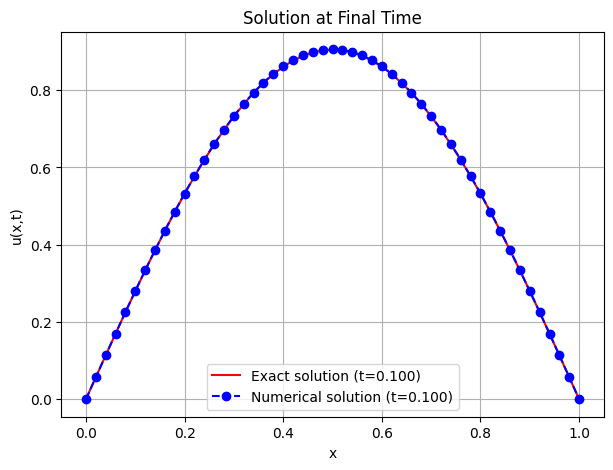

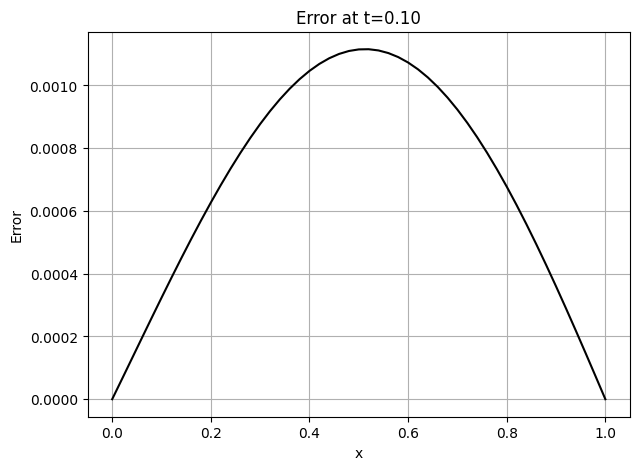

In [4]:
import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt

# ------------------------- Параметры задачи -------------------------
N = 50             # Число промежутков по x -> сетка из N+1 точек
h = 1.0 / N        # Шаг по x
x = np.linspace(0, 1, N+1)

T_final = 0.1      # Конечное время
dt = 0.001         # Шаг по времени
gamma = 1.0        # Параметр для (упрощённой) Rosenbrock-схемы

# ------------------------- Точное решение и f(x,t) -------------------------
def u_exact(x, t):
    """Точное решение: u(x,t) = e^{-t} * sin(pi*x)."""
    return np.exp(-t) * np.sin(np.pi * x)

def f_func(x, t):
    """
    Правая часть PDE:
        u_t = (x+2)*u_xx + 2*u_x + f(x,t).
    Выбираем f так, чтобы u_exact было точным решением.
    """
    return np.exp(-t)*(
        (np.pi**2*(x+2) - 1)*np.sin(np.pi*x) 
        - 2*np.pi*np.cos(np.pi*x)
    )

# ------------------------- Начальное условие -------------------------
U_full = u_exact(x, 0.0)  # полное решение (включая граничные точки)
# Но у нас границы 0 и 1, где u(0,t)=u(1,t)=0, что согласуется с u_exact.

# ------------------ Формируем полусвязную систему для внутренних узлов ------------------
M = N - 1  # число внутренних узлов
A = np.zeros((M, M))

for k in range(M):
    j = k + 1  # индекс во всей сетке x
    xj = x[j]

    # Коэффициент (x+2)/h^2
    coeff = (xj + 2) / (h**2)

    # учёт члена 2*u_x ~ 2*(u_{j+1} - u_{j-1}) / (2h) => + (1/h) для верхней диагонали и - (1/h) для нижней
    A[k, k] -= 2 * coeff            # диагональ
    if k < M - 1:
        A[k, k + 1] += coeff + (1.0/h)    # верхняя диагональ
    if k > 0:
        A[k, k - 1] += coeff - (1.0/h)    # нижняя диагональ

I = np.eye(M)

def RHS_func(U_interior, t):
    """
    Прав. часть для внутренних узлов:
    (x+2)*u_xx + 2*u_x + f(x,t), 
    с учётом того, что на границах u=0.
    """
    # Полное решение с учетом границ = 0
    U_tmp = np.zeros(N+1)
    U_tmp[1:-1] = U_interior

    # f(x_j, t) на j=1..N-1
    f_vals = np.array([f_func(x[j], t) for j in range(1, N)])
    
    return A @ U_interior + f_vals

# ------------------------- Цикл по времени -------------------------
steps = int(T_final / dt)
times = np.linspace(0, T_final, steps+1)  # массив временных узлов

# Начальная "внутренняя" часть решения (исключая граничные точки)
U_interior = U_full[1:-1].copy()

# Здесь будем хранить решение на каждом шаге (только внутренние узлы)
solutions_over_time = []
solutions_over_time.append(U_interior.copy())

# Массив для хранения ошибок (например, возьмём макс. норму)
errors_in_time = []

# Считаем ошибку в момент t=0 (для наглядности)
U_0_full = np.zeros(N+1)
U_0_full[1:-1] = U_interior
error_0 = np.max(np.abs(U_0_full - u_exact(x, 0.0)))
errors_in_time.append(error_0)

# Основной цикл по времени
for step in range(steps):
    t_n = times[step]    # текущее время
    RHS = RHS_func(U_interior, t_n)

    # Решаем (I - gamma*dt*A)*K = RHS
    LHS = (I - gamma * dt * A)
    K = solve(LHS, RHS)

    # U^{n+1} = U^n + dt * K
    U_interior = U_interior + dt * K

    # Сохраняем решение
    solutions_over_time.append(U_interior.copy())

    # Вычисляем ошибку в момент времени t_{n+1}
    # Полное решение (с граничными условиями)
    U_num_full = np.zeros(N+1)
    U_num_full[1:-1] = U_interior
    # Точное решение в момент times[step+1]
    U_ex_full = u_exact(x, times[step+1])
    # Макс. ошибка
    err = np.max(np.abs(U_num_full - U_ex_full))
    errors_in_time.append(err)

# ------------------------- Анализ и вывод результатов -------------------------

# 1) Выведем, например, максимальную ошибку за всё время
max_error = np.max(errors_in_time)
print(f"Max error over [0, {T_final}]: {max_error:.6e}")

# 2) Выведем среднюю ошибку за всё время (по массиву errors_in_time)
mean_error = np.mean(errors_in_time)
print(f"Mean error over [0, {T_final}]: {mean_error:.6e}")

# 3) Построим график ошибки по времени
plt.figure(figsize=(7,5))
plt.plot(times, errors_in_time, 'ro--')
plt.xlabel('time')
plt.ylabel('Error (max norm)')
plt.title('Error vs Time')
plt.grid(True)
plt.show()

# 4) Покажем также решение в последний момент времени
U_num_final_full = np.zeros(N+1)
U_num_final_full[1:-1] = solutions_over_time[-1]
U_ex_final = u_exact(x, T_final)

plt.figure(figsize=(7,5))
plt.plot(x, U_ex_final, 'r-', label='Exact solution (t=%.3f)' % T_final)
plt.plot(x, U_num_final_full, 'bo--', label='Numerical solution (t=%.3f)' % T_final)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution at Final Time')
plt.grid(True)
plt.legend()
plt.show()

# 5) И нарисуем профиль ошибки в последний момент
plt.figure(figsize=(7,5))
plt.plot(x, U_num_final_full - U_ex_final, 'k-')
plt.xlabel('x')
plt.ylabel('Error')
plt.title(f'Error at t={T_final:.2f}')
plt.grid(True)
plt.show()


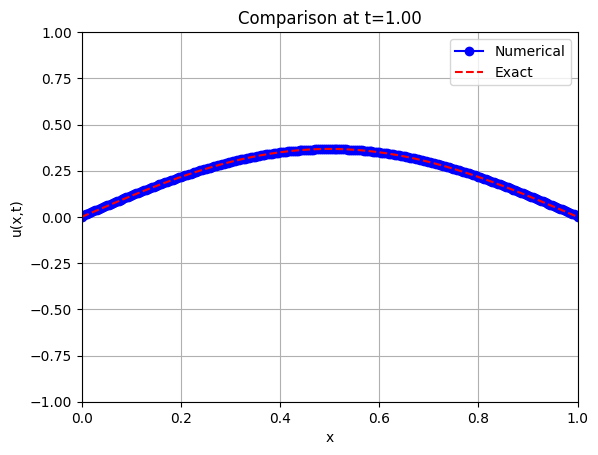

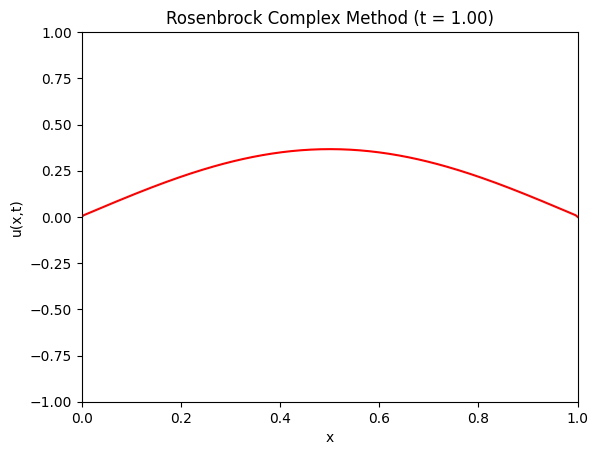

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve
from matplotlib.animation import FuncAnimation, PillowWriter

def f_func(x, t):
    # f(x,t) for the chosen exact solution
    # f(x,t) = e^{-t}[(\pi^2(x+2)-1)*sin(\pi x) - 2\pi*cos(\pi x)]
    return np.exp(-t)*((np.pi**2*(x+2)-1)*np.sin(np.pi*x) - 2*np.pi*np.cos(np.pi*x))

def alpha(t):
    # Boundary condition at x=0
    return 0.0

def beta(t):
    # Boundary condition at x=1
    return 0.0

def u_exact(x, t):
    # Exact solution u(x,t) = e^{-t} sin(pi x)
    return np.exp(-t)*np.sin(np.pi*x)

def rosenbrock_complex(Nx, Nt, T, alpha, beta, f_func):
    L = 1.0  
    dx = L / (Nx - 1)
    dt = T / Nt
    x = np.linspace(0, L, Nx)
    t = np.linspace(0, T, Nt)
    tau = dt
    
    # Rosenbrock complex parameter
    xi = (1 + 1j) / 2.0

    # We form the spatial discretization for:
    # u_t = (x+2)*u_xx + 2*u_x + f(x,t)
    #
    # Approximations:
    # u_xx(i) ≈ (u_{i+1} - 2u_i + u_{i-1}) / dx^2
    # u_x(i)  ≈ (u_{i+1} - u_{i-1}) / (2*dx)
    #
    # Substitute into PDE:
    # u_t(i) = (x_i+2)*(u_{i+1}-2u_i+u_{i-1})/dx^2 + ( (u_{i+1}-u_{i-1})/dx ) + f_i
    #
    # Collecting coefficients for the linear operator Lambda on u:
    # main diagonal: -2*(x_i+2)/dx^2
    # upper diagonal: (x_i+2)/dx^2 + 1/dx
    # lower diagonal: (x_i+2)/dx^2 - 1/dx
    #
    # We'll construct these diagonals vectorized. Note that x_i varies with i.

    x_inner = x  # x for all grid points; we will just apply boundaries after solution

    # For each interior point i, define coefficients:
    # We have Nx points from 0 to Nx-1.
    # The operator applies to all points including boundaries, but we set BCs after.

    # Create arrays for diagonals
    diag_main = np.zeros(Nx)
    diag_upper = np.zeros(Nx-1)
    diag_lower = np.zeros(Nx-1)

    for i in range(Nx):
        xi_val = x_inner[i]
        if 0 < i < Nx-1:
            # interior points
            diag_main[i] = -2*(xi_val+2)/dx**2
        else:
            # The boundary points will be overwritten by BCs after each step,
            # but we still define them here.
            diag_main[i] = -2*(xi_val+2)/dx**2

    for i in range(Nx-1):
        x_left = x_inner[i]
        x_right = x_inner[i+1]
        # For upper diagonal (connects i to i+1)
        # We should use x_i for consistency in the operator at index i:
        # Actually the operator in finite differences is typically centered at i,
        # so for the upper diagonal corresponding to position i, we use x_i:
        xi_val = x_inner[i]
        diag_upper[i] = (xi_val+2)/dx**2 + (1.0/dx)

        # For lower diagonal (connects i+1 to i)
        # It corresponds to the point x_{i+1}, so let's be consistent:
        xj_val = x_inner[i+1]
        diag_lower[i] = (xj_val+2)/dx**2 - (1.0/dx)

    # For the very first and last point (i=0, i=Nx-1), the operator is not fully meaningful
    # because of boundary conditions. We'll just keep it and then enforce BCs later.

    # Construct sparse matrix
    Lambda = diags(
        [diag_lower, diag_main, diag_upper],
        offsets=[-1, 0, 1],
        format="csc"
    )

    I = diags([1.0]*Nx, offsets=0, format="csc")

    # Initial condition
    u = u_exact(x, 0.0)

    u_history = [u.copy()]

    for n in range(1, Nt):
        current_t = t[n]

        # Compute forcing term f(x,t)
        F_val = f_func(x, current_t)

        # PDE: u_t = Lambda*u + f  -> u_t = (x+2)*u_xx + 2*u_x + f
        # Here, Lambda represents the spatial operator without the f.
        # The right-hand side for Rosenbrock step: F = f + Lambda*u
        RHS = F_val + Lambda @ u

        # Solve stage equation:
        # (I - xi*tau*Lambda) z1 = F
        # Then u_{n+1} = u_n + tau * real(z1)
        LHS = (I - xi*tau*Lambda)

        z1 = spsolve(LHS, RHS)

        u_new = u + tau * np.real(z1)

        # Apply boundary conditions
        u_new[0] = alpha(current_t)
        u_new[-1] = beta(current_t)

        u = u_new
        u_history.append(u.copy())

    return x, t, u_history

def main():
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation, PillowWriter

    Nx = 256
    Nt = 16
    T = 1.0

    x, t, u_history = rosenbrock_complex(Nx, Nt, T, alpha, beta, f_func)

    # Compare with exact solution at final time
    u_exact_final = u_exact(x, T)

    fig, ax = plt.subplots()
    line1, = ax.plot(x, u_history[-1], 'bo-', label='Numerical')
    line2, = ax.plot(x, u_exact_final, 'r--', label='Exact')
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel("x")
    ax.set_ylabel("u(x,t)")
    ax.set_title("Comparison at t={:.2f}".format(T))
    ax.legend()
    plt.grid(True)
    plt.show()

    # Create an animation of the numerical solution evolving in time
    fig2, ax2 = plt.subplots()
    line_anim, = ax2.plot(x, u_history[0], color="red")
    ax2.set_xlim(0, 1)
    ax2.set_ylim(-1, 1)
    ax2.set_xlabel("x")
    ax2.set_ylabel("u(x,t)")
    ax2.set_title("Rosenbrock Complex Method")

    def update(frame):
        line_anim.set_ydata(u_history[frame])
        ax2.set_title(f"Rosenbrock Complex Method (t = {t[frame]:.2f})")
        return line_anim,

    ani = FuncAnimation(fig2, update, frames=len(u_history), blit=True)
    ani.save("solution.gif", writer=PillowWriter(fps=1))
    plt.show()

if __name__ == "__main__":
    main()


In [68]:
# Проверка метода CROS на модельной задаче(3-ая задача)


import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve
from matplotlib.animation import FuncAnimation, PillowWriter


def initial_condition(x, delta):
    return np.where( (x >= 0.5 - delta) & (x <= 0.5 + delta), 1.0, 0.0 )

def solve_heat_rosenbrock(Nx, Nt, T, delta):
    L = 1.0
    dx = L / (Nx - 1)
    dt = T / (Nt - 1)

    x = np.linspace(0, L, Nx)     
    t = np.linspace(0, T, Nt)    

    xi = (1 + 1j)/2.0

    diag_main = np.zeros(Nx, dtype=np.complex128)
    diag_upper = np.zeros(Nx-1, dtype=np.complex128)
    diag_lower = np.zeros(Nx-1, dtype=np.complex128)

    for i in range(1, Nx-1):
        diag_main[i]  = -2.0/dx**2
        diag_upper[i] = 1.0/dx**2
        diag_lower[i-1] = 1.0/dx**2

    A = diags([diag_lower, diag_main, diag_upper], offsets=[-1, 0, 1], format='csc')

    row0 = np.zeros(Nx, dtype=np.complex128)
    row0[0] = 1.0
    A[0,:] = row0

    rowN = np.zeros(Nx, dtype=np.complex128)
    rowN[-1] = 1.0
    A[-1,:] = rowN

    I = diags([1.0]*Nx, 0, format='csc')

    u0 = initial_condition(x, delta)
    u_history = [u0.copy()]

    u = u0.copy()
    for n in range(1, Nt):
        RHS = A @ u

        LHS = (I - xi*dt*A)
        z1  = spsolve(LHS, RHS)

        u_new = u + dt*np.real(z1)

        u_new[0] = 0.0
        u_new[-1] = 0.0

        u = u_new
        u_history.append(u.copy())

    return x, t, u_history

In [71]:
def main():
    Nx = 256   
    Nt = 100   
    T  = 0.2  
    delta = 0.125 

    x, t_vals, u_data = solve_heat_rosenbrock(Nx, Nt, T, delta)

    plt.figure()
    plt.plot(x, u_data[-1], 'r-o', label=f'u(x,T={T})')
    plt.xlabel("x")
    plt.ylabel("u(x,T)")
    plt.title("№3 Task")
    plt.grid(True)
    plt.legend()
    plt.show()

    fig, ax = plt.subplots()
    line, = ax.plot(x, u_data[0], color="blue")
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel("x")
    ax.set_ylabel("u(x,t)")
    ax.set_title(f"t=0.00")

    def update(frame):
        line.set_ydata(u_data[frame])
        ax.set_title(f"t={t_vals[frame]:.3f}")
        return line,

    ani = FuncAnimation(fig, update, frames=len(u_data), interval=50, blit=True)
    
    ani.save("Rosenbrock_3task.gif", writer=PillowWriter(fps=5))
    plt.show()

c:\Users\danii\anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


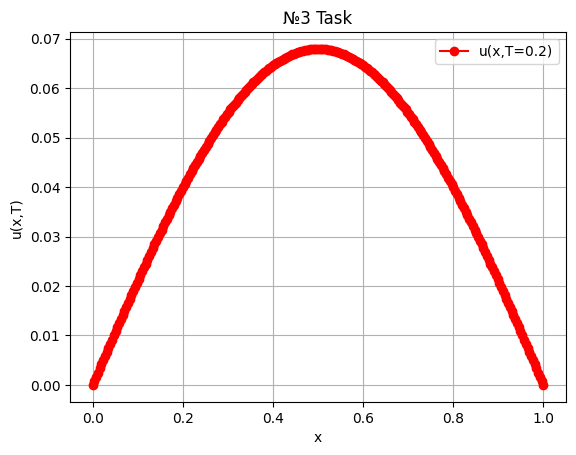

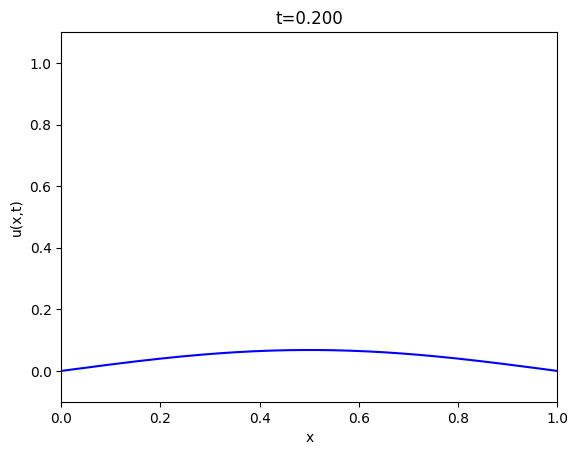

In [72]:
if __name__=="__main__":
    main()

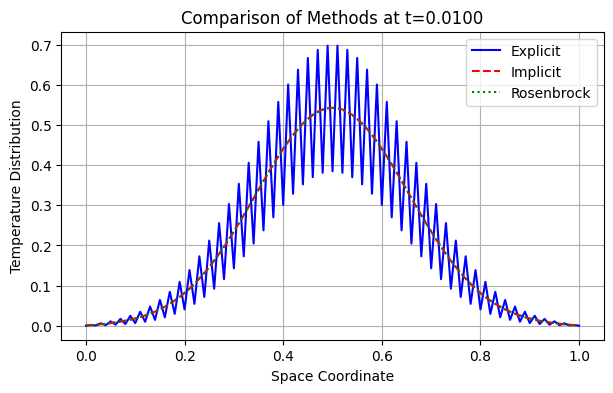

L2 Differences Between Final States:
  Explicit vs Implicit: 0.091861
  Explicit vs Rosenbrock: 0.091859
  Implicit vs Rosenbrock: 0.000312


In [63]:
# Сравнение метода CROS и явной\неявной РС на модельной задаче(3-ая задача)

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve

num_nodes = 101
length = 1.0
space_step = length / (num_nodes - 1)

final_time = 0.01
time_intervals = 200
time_step = final_time / (time_intervals - 1)

region_half_width = 0.1

space_coords = np.linspace(0, length, num_nodes)
time_coords = np.linspace(0, final_time, time_intervals)

def initialize_condition(coords, half_width):
    return np.where((coords >= 0.5 - half_width) & (coords <= 0.5 + half_width), 1.0, 0.0)

initial_state = initialize_condition(space_coords, region_half_width)

def solve_rosenbrock_method(init_state, num_nodes, time_intervals, space_step, time_step):
    main_diag = np.zeros(num_nodes, dtype=complex)
    upper_diag = np.zeros(num_nodes - 1, dtype=complex)
    lower_diag = np.zeros(num_nodes - 1, dtype=complex)

    for index in range(1, num_nodes - 1):
        main_diag[index] = -2.0 / (space_step ** 2)
        upper_diag[index] = 1.0 / (space_step ** 2)
        lower_diag[index - 1] = 1.0 / (space_step ** 2)

    matrix_A = diags([lower_diag, main_diag, upper_diag], offsets=[-1, 0, 1], format='csc')

    matrix_A[0, :] = np.zeros(num_nodes, dtype=complex)
    matrix_A[0, 0] = 1.0
    matrix_A[-1, :] = np.zeros(num_nodes, dtype=complex)
    matrix_A[-1, -1] = 1.0

    identity_matrix = csc_matrix(np.eye(num_nodes, dtype=complex))
    complex_factor = (1 + 1j) / 2.0

    current_state = init_state.copy()
    solution_history = [current_state.copy()]

    for _ in range(1, time_intervals):
        rhs = matrix_A @ current_state
        temp_matrix = identity_matrix - complex_factor * time_step * matrix_A
        intermediate = spsolve(temp_matrix, rhs)

        next_state = current_state + time_step * np.real(intermediate)
        next_state[0] = 0.0
        next_state[-1] = 0.0

        current_state = next_state
        solution_history.append(current_state.copy())

    return solution_history

def solve_explicit_method(init_state, num_nodes, time_intervals, space_step, time_step):
    current_state = init_state.copy()
    solution_history = [current_state.copy()]

    alpha_factor = time_step / (space_step ** 2)

    for _ in range(1, time_intervals):
        next_state = current_state.copy()
        for index in range(1, num_nodes - 1):
            next_state[index] = current_state[index] + alpha_factor * (current_state[index + 1] - 2 * current_state[index] + current_state[index - 1])
        next_state[0] = 0.0
        next_state[-1] = 0.0

        current_state = next_state
        solution_history.append(current_state.copy())

    return solution_history

def solve_implicit_method(init_state, num_nodes, time_intervals, space_step, time_step):
    main_diag = np.zeros(num_nodes)
    upper_diag = np.zeros(num_nodes - 1)
    lower_diag = np.zeros(num_nodes - 1)

    for index in range(1, num_nodes - 1):
        main_diag[index] = -2.0 / (space_step ** 2)
        upper_diag[index] = 1.0 / (space_step ** 2)
        lower_diag[index - 1] = 1.0 / (space_step ** 2)

    matrix_A = diags([lower_diag, main_diag, upper_diag], offsets=[-1, 0, 1], format='csc')

    matrix_A[0, :] = np.zeros(num_nodes)
    matrix_A[0, 0] = 1.0
    matrix_A[-1, :] = np.zeros(num_nodes)
    matrix_A[-1, -1] = 1.0

    identity_matrix = csc_matrix(np.eye(num_nodes))
    coefficient_matrix = identity_matrix - time_step * matrix_A

    current_state = init_state.copy()
    solution_history = [current_state.copy()]

    for _ in range(1, time_intervals):
        rhs_vector = current_state.copy()
        rhs_vector[0] = 0.0
        rhs_vector[-1] = 0.0
        next_state = spsolve(coefficient_matrix, rhs_vector)

        current_state = next_state
        solution_history.append(current_state.copy())

    return solution_history

def calculate_l2_difference(state1, state2, space_step):
    return np.sqrt(space_step * np.sum((state1 - state2) ** 2))

def main():
    explicit_result = solve_explicit_method(initial_state, num_nodes, time_intervals, space_step, time_step)
    implicit_result = solve_implicit_method(initial_state, num_nodes, time_intervals, space_step, time_step)
    rosenbrock_result = solve_rosenbrock_method(initial_state, num_nodes, time_intervals, space_step, time_step)

    final_explicit = explicit_result[-1]
    final_implicit = implicit_result[-1]
    final_rosenbrock = rosenbrock_result[-1]

    plt.figure(figsize=(7, 4))
    plt.plot(space_coords, final_explicit, 'b-', label="Explicit")
    plt.plot(space_coords, final_implicit, 'r--', label="Implicit")
    plt.plot(space_coords, final_rosenbrock, 'g:', label="Rosenbrock")
    plt.xlabel('Space Coordinate')
    plt.ylabel('Temperature Distribution')
    plt.title("Comparison of Methods at t=%.4f" % final_time)
    plt.legend()
    plt.grid(True)
    plt.show()

    error_explicit_vs_implicit = calculate_l2_difference(final_explicit, final_implicit, space_step)
    error_explicit_vs_rosenbrock = calculate_l2_difference(final_explicit, final_rosenbrock, space_step)
    error_implicit_vs_rosenbrock = calculate_l2_difference(final_implicit, final_rosenbrock, space_step)

    print("L2 Differences Between Final States:")
    print(f"  Explicit vs Implicit: {error_explicit_vs_implicit:.6f}")
    print(f"  Explicit vs Rosenbrock: {error_explicit_vs_rosenbrock:.6f}")
    print(f"  Implicit vs Rosenbrock: {error_implicit_vs_rosenbrock:.6f}")

if __name__ == "__main__":
    main()
